In [23]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
from kam11 import context, matchedField, thermister, rayModeling
from beamforming import curvedWaveFront, timeDomain
from kam11.plotting import mfPlotting
import matplotlib.pyplot as plt
import scipy.signal as sig
import os
from scipy.signal import resample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
timeOfInterest='2011 J184 03:51:15'
loadDuration=dt.timedelta(0,5)
thetaRange=(4,8)
numTheta=500
beamformingStart=-5
beamformingEnd=-2
numBeams=500
#Choose a single snapshot index for beamforming
snapshotIndex=10

#Model simulation
bellhopFilesDir='/Users/edwardlrichards/cir_processing'+\
                '/bellhopFiles/beamforming'

#figure saving
figSaveDir='/Users/edwardlrichards/cir_processing/beamforming_072915'
resampleRate=10


In [25]:
tof = dt.datetime.strptime(timeOfInterest, '%Y J%j %H:%M:%S')

ssp=thermister.getSoundSpeed(tof)
rd=context.VLA1(tof).phoneDepths()

In [26]:
cirEstimate=matchedField.LFM_MatchedFilter(tof,
                                           loadDuration=loadDuration)
# mf=cirEstimate.matchedFilter(baseBand=False)
mf=cirEstimate.matchedFilter()

In [27]:
fastTime=mf[mf['channelNames'][0]].index
def getSingleSnap():
    for m in mf['channelNames']:
        yield(mf[m].iloc[:,snapshotIndex])
lookData=pd.DataFrame(list(getSingleSnap()),\
        index=mf['channelNames'],columns=fastTime).T

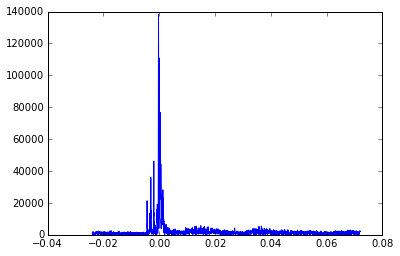

In [38]:
testSignal=lookData[1]
_=plt.plot(lookData.index, np.abs(testSignal))

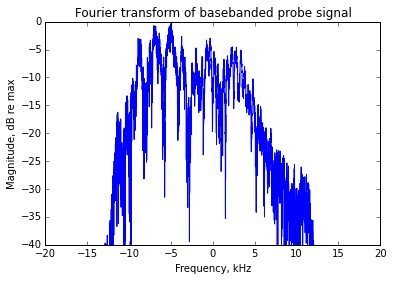

In [53]:
fAxis = np.arange(testSignal.size)/testSignal.size*context.fs
fAxis -= context.fs / 2
F = np.fft.fft(testSignal)
FDB = 20 * np.log10(np.abs(F))
FDB -= np.max(FDB)
_=plt.plot(fAxis/1e3, np.fft.fftshift(FDB))
_=plt.ylim(-40,0)
_=plt.xlim(-20,20)
_=plt.ylabel('Magnitude, dB re max')
_=plt.xlabel('Frequency, kHz')
_=plt.title('Fourier transform of basebanded probe signal')

In [28]:
thetaTest=np.r_[thetaRange[0]:thetaRange[1]:1j*numTheta]
testDelay=curvedWaveFront.getDelays(thetaTest, ssp, rd, z0=rd[1])

centerTime=np.r_[beamformingStart:beamformingEnd:1j*numBeams]
centerTime/=1e3

In [29]:
#Data beamforming
beamD=timeDomain.timeBeamformer(lookData, centerTime,
                                testDelay, upsample=1)

In [57]:
lookDB=20*np.log10(np.abs(np.array(beamD))+np.spacing(1))
np.max(lookDB)

102.0421939011262

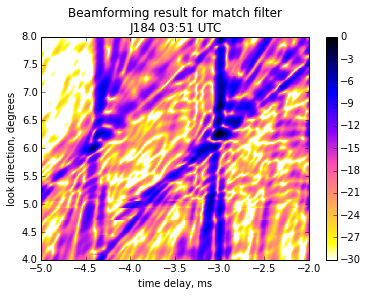

In [30]:
lookDB=20*np.log10(np.abs(np.array(beamD))+np.spacing(1))
lookDB-=np.max(lookDB)
X,Y=np.meshgrid(1e3*centerTime,thetaTest)
fig,ax=plt.subplots()
pc=ax.pcolormesh(X,Y,lookDB.T,vmin=-30,vmax=0,cmap=plt.cm.gnuplot2_r)
cb=fig.colorbar(pc)
# _=cb.set_ticks([-40,-30-20,-10,0])
# _=ax.set_xlim(beamformingStart,beamformingEnd)
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
_=ax.set_xlabel('time delay, ms')
_=ax.set_ylabel('look direction, degrees')
_=ax.set_title('Beamforming result for match filter \n'+\
              '%s'%tof.strftime('J%j %H:%M UTC'))
savename='mfBeams_%s'%tof.strftime('J%j_%H_%M')
fig.savefig(os.path.join(figSaveDir,savename))
# plt.savefig('/Users/edwardlrichards/ipythonNotebooks/KAM 11 enviornment/curvedWaveFronts/figures/arrivals')

In [31]:
#Data beamforming
beamDUP=timeDomain.timeBeamformer(lookData, centerTime,
                                  testDelay, upsample=resampleRate)

In [56]:
lookDB=20*np.log10(np.abs(np.array(beamDUP))+np.spacing(1))
np.max(lookDB)

102.18212146486835

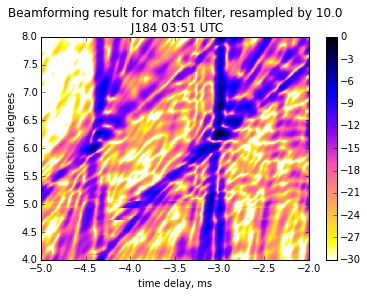

In [32]:
lookDB=20*np.log10(np.abs(np.array(beamDUP))+np.spacing(1))
lookDB-=np.max(lookDB)
X,Y=np.meshgrid(1e3*centerTime,thetaTest)
fig,ax=plt.subplots()
pc=ax.pcolormesh(X,Y,lookDB.T,vmin=-30,vmax=0,cmap=plt.cm.gnuplot2_r)
cb=fig.colorbar(pc)
# _=cb.set_ticks([-40,-30-20,-10,0])
# _=ax.set_xlim(beamformingStart,beamformingEnd)
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
_=ax.set_xlabel('time delay, ms')
_=ax.set_ylabel('look direction, degrees')
_=ax.set_title('Beamforming result for match filter, '+\
               'resampled by %0.1f\n %s'\
               %(resampleRate,tof.strftime('J%j %H:%M UTC')))
savename='mfBeams_%s_re'%tof.strftime('J%j_%H_%M')
fig.savefig(os.path.join(figSaveDir,savename))
# plt.savefig('/Users/edwardlrichards/ipythonNotebooks/KAM 11 enviornment/curvedWaveFronts/figures/arrivals')

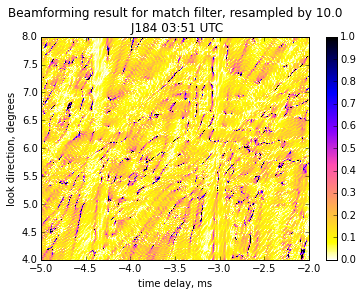

In [65]:
look1=20*np.log10(np.abs(np.array(beamDUP))+np.spacing(1))
look2=20*np.log10(np.abs(np.array(beamD))+np.spacing(1))
DB=np.abs(look1-look2)
X,Y=np.meshgrid(1e3*centerTime,thetaTest)
fig,ax=plt.subplots()
# pc=ax.pcolormesh(X,Y,DB.T,cmap=plt.cm.gnuplot2_r)
pc=ax.pcolormesh(X,Y,DB.T,vmin=0,vmax=1,cmap=plt.cm.gnuplot2_r)
cb=fig.colorbar(pc)
# _=cb.set_ticks([-40,-30-20,-10,0])
# _=ax.set_xlim(beamformingStart,beamformingEnd)
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
_=ax.set_xlabel('time delay, ms')
_=ax.set_ylabel('look direction, degrees')
_=ax.set_title('Beamforming result for match filter, '+\
               'resampled by %0.1f\n %s'\
               %(resampleRate,tof.strftime('J%j %H:%M UTC')))
savename='mfBeams_%s_re'%tof.strftime('J%j_%H_%M')
fig.savefig(os.path.join(figSaveDir,savename))
# plt.savefig('/Users/edwardlrichards/ipythonNotebooks/KAM 11 enviornment/curvedWaveFronts/figures/arrivals')